In [1]:
path = 'C:/Users/gauth/Desktop/PGPDM/modelling_project/'

In [81]:
import pandas as pd 
import numpy as np
import math as m
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
%matplotlib inline

Importing the train and test datasets 

In [47]:
traindf = pd.read_csv(path+"train.csv")
testdf = pd.read_csv(path+"test.csv")

print(traindf.shape)
print(testdf.shape)

(30471, 292)
(7662, 291)


We will be trying to predict the price of houses using all the other variables in the dataset. The dataset also has a timestamp component to it.Let's visualize the price variable.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count         30471
mean        7123035
std         4780111
min          100000
25%         4740002
50%         6274411
75%         8300000
max       111111112
Name: price_doc, dtype: object



Price range skewness 4.474524591691862


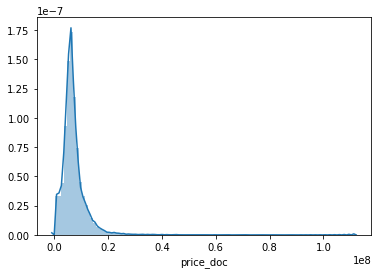

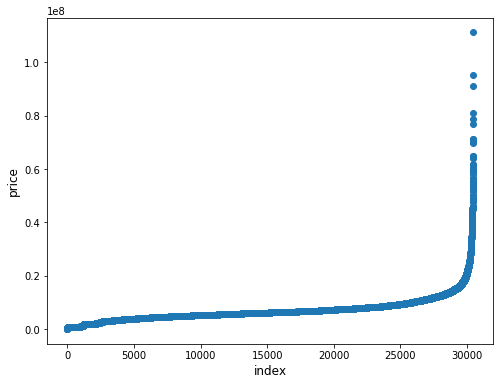

In [48]:
sns.distplot(traindf["price_doc"],bins = 100)
print(traindf["price_doc"].describe().apply(lambda x : format(x,'10.0f')))
print("\n\n\nPrice range skewness",stats.skew(traindf["price_doc"]))
plt.figure(figsize=(8,6))
plt.scatter(range(traindf.shape[0]), np.sort(traindf.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

In [5]:
list(np.percentile(traindf["price_doc"], np.arange(0, 100, 2)))

[100000.0,
 1000000.0,
 1669748.3999999976,
 2000000.0,
 2552421.0,
 3000000.0,
 3386385.2,
 3690164.0,
 3925805.9999999995,
 4101772.3999999994,
 4319500.0,
 4500000.0,
 4650000.0,
 4806371.0,
 4990000.0,
 5100000.0,
 5226412.0,
 5360000.0,
 5500000.0,
 5600000.0,
 5700000.0,
 5818133.0,
 5938503.199999999,
 6024020.0,
 6150600.0,
 6274411.0,
 6390000.0,
 6500000.0,
 6600000.0,
 6726686.0,
 6900000.0,
 7000000.0,
 7200000.0,
 7350000.0,
 7500000.0,
 7700000.0,
 7923741.0,
 8169766.0,
 8400000.0,
 8665095.200000007,
 9000000.0,
 9391032.6,
 9900000.0,
 10414315.600000001,
 11000000.0,
 11800000.0,
 12638292.000000006,
 13800000.0,
 15500000.0,
 19189159.999999963]

We see that the price range is postively skewed with a long tail, with 98% of the prices less than 20 mil  

The timestamp variable might be important in viewing the whole problem. Let's look at it

In [49]:
print("NAs in Price Doc column",traindf["price_doc"].isnull().sum(),"\n")
print("Train Data")
print("min date:",traindf["timestamp"].min())
print("max date:",traindf["timestamp"].max())
print("number of nulls",traindf["timestamp"].isna().value_counts())

print("\nTest Data")
print("min date:",testdf["timestamp"].min())
print("max date:",testdf["timestamp"].max())
print("number of nulls",testdf["timestamp"].isna().value_counts())

print("\nTime variable type before conversion: ",traindf['timestamp'].dtype)

NAs in Price Doc column 0 

Train Data
min date: 2011-08-20
max date: 2015-06-30
number of nulls False    30471
Name: timestamp, dtype: int64

Test Data
min date: 2015-07-01
max date: 2016-05-30
number of nulls False    7662
Name: timestamp, dtype: int64

Time variable type before conversion:  object


The test and the train datasets are split by time series. We have to learn from the past and predict the future

In [50]:
traindf["timestamp"]=pd.to_datetime(traindf['timestamp'])
testdf["timestamp"]=pd.to_datetime(testdf['timestamp'])
print("Time variable type : ",traindf['timestamp'].dtype)

traindf["year"] = traindf["timestamp"].dt.year
traindf["month"] = traindf["timestamp"].dt.month
testdf["year"] = testdf["timestamp"].dt.year
testdf["month"] = testdf["timestamp"].dt.month

Time variable type :  datetime64[ns]


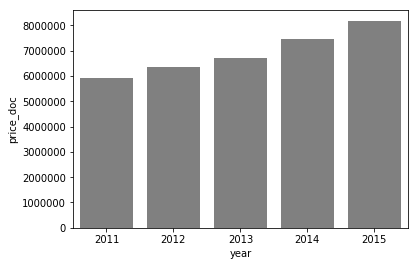

In [51]:
mean = pd.DataFrame(traindf.groupby(traindf["year"])["price_doc"].agg('mean').apply(lambda x : format(x,'10.0f')))
mean["price_doc"]=mean["price_doc"].astype(int)
mean.reset_index(level=0, inplace=True)
sns.barplot(x="year",y="price_doc",data=mean, color="grey")

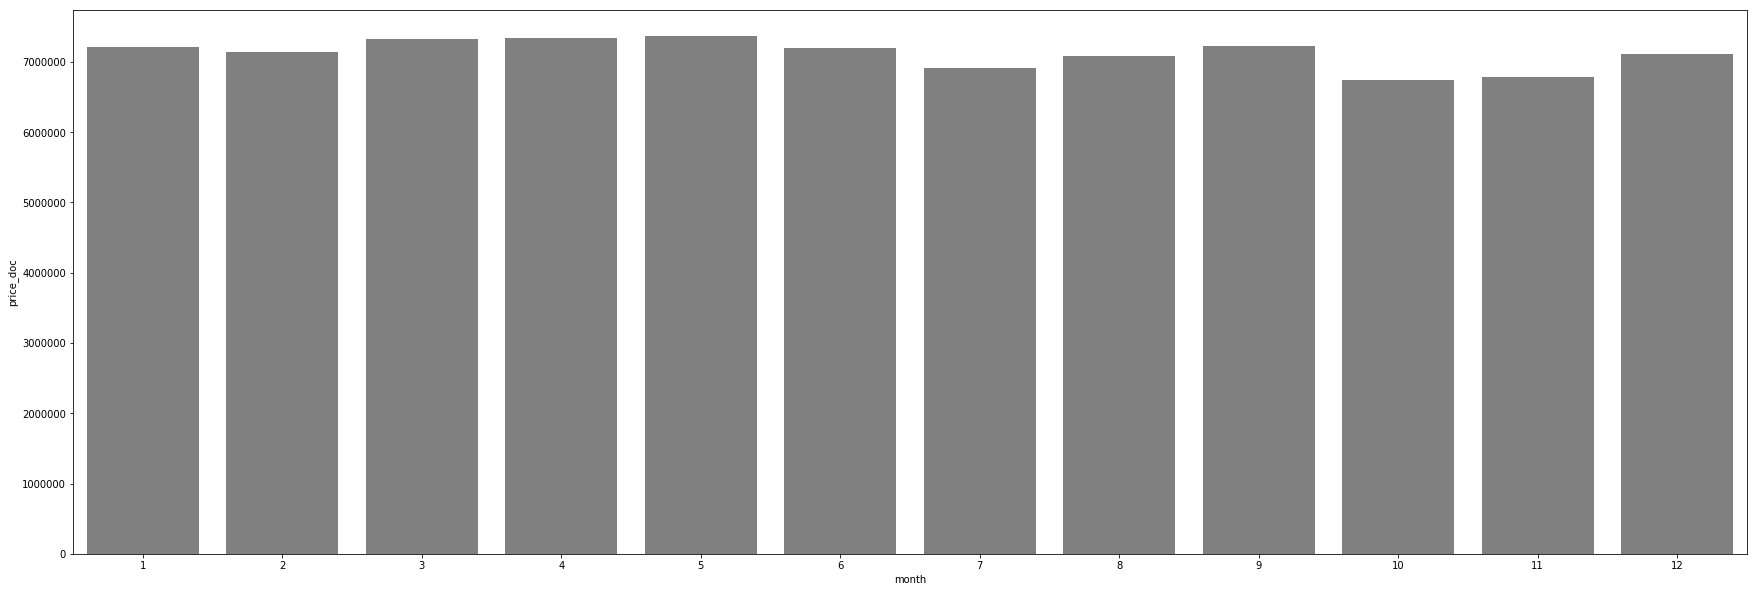

In [14]:
mean = pd.DataFrame(traindf.groupby([traindf["month"]])["price_doc"].agg('mean').apply(lambda x : format(x,'10.0f')))
mean["price_doc"]=mean["price_doc"].astype(int)
mean["month"]= mean.index
#mean.reset_index(level=0, inplace=True)
plt.figure(figsize=(30,10))
sns.barplot(x="month",y="price_doc",data=mean,color="grey")
plt.show()

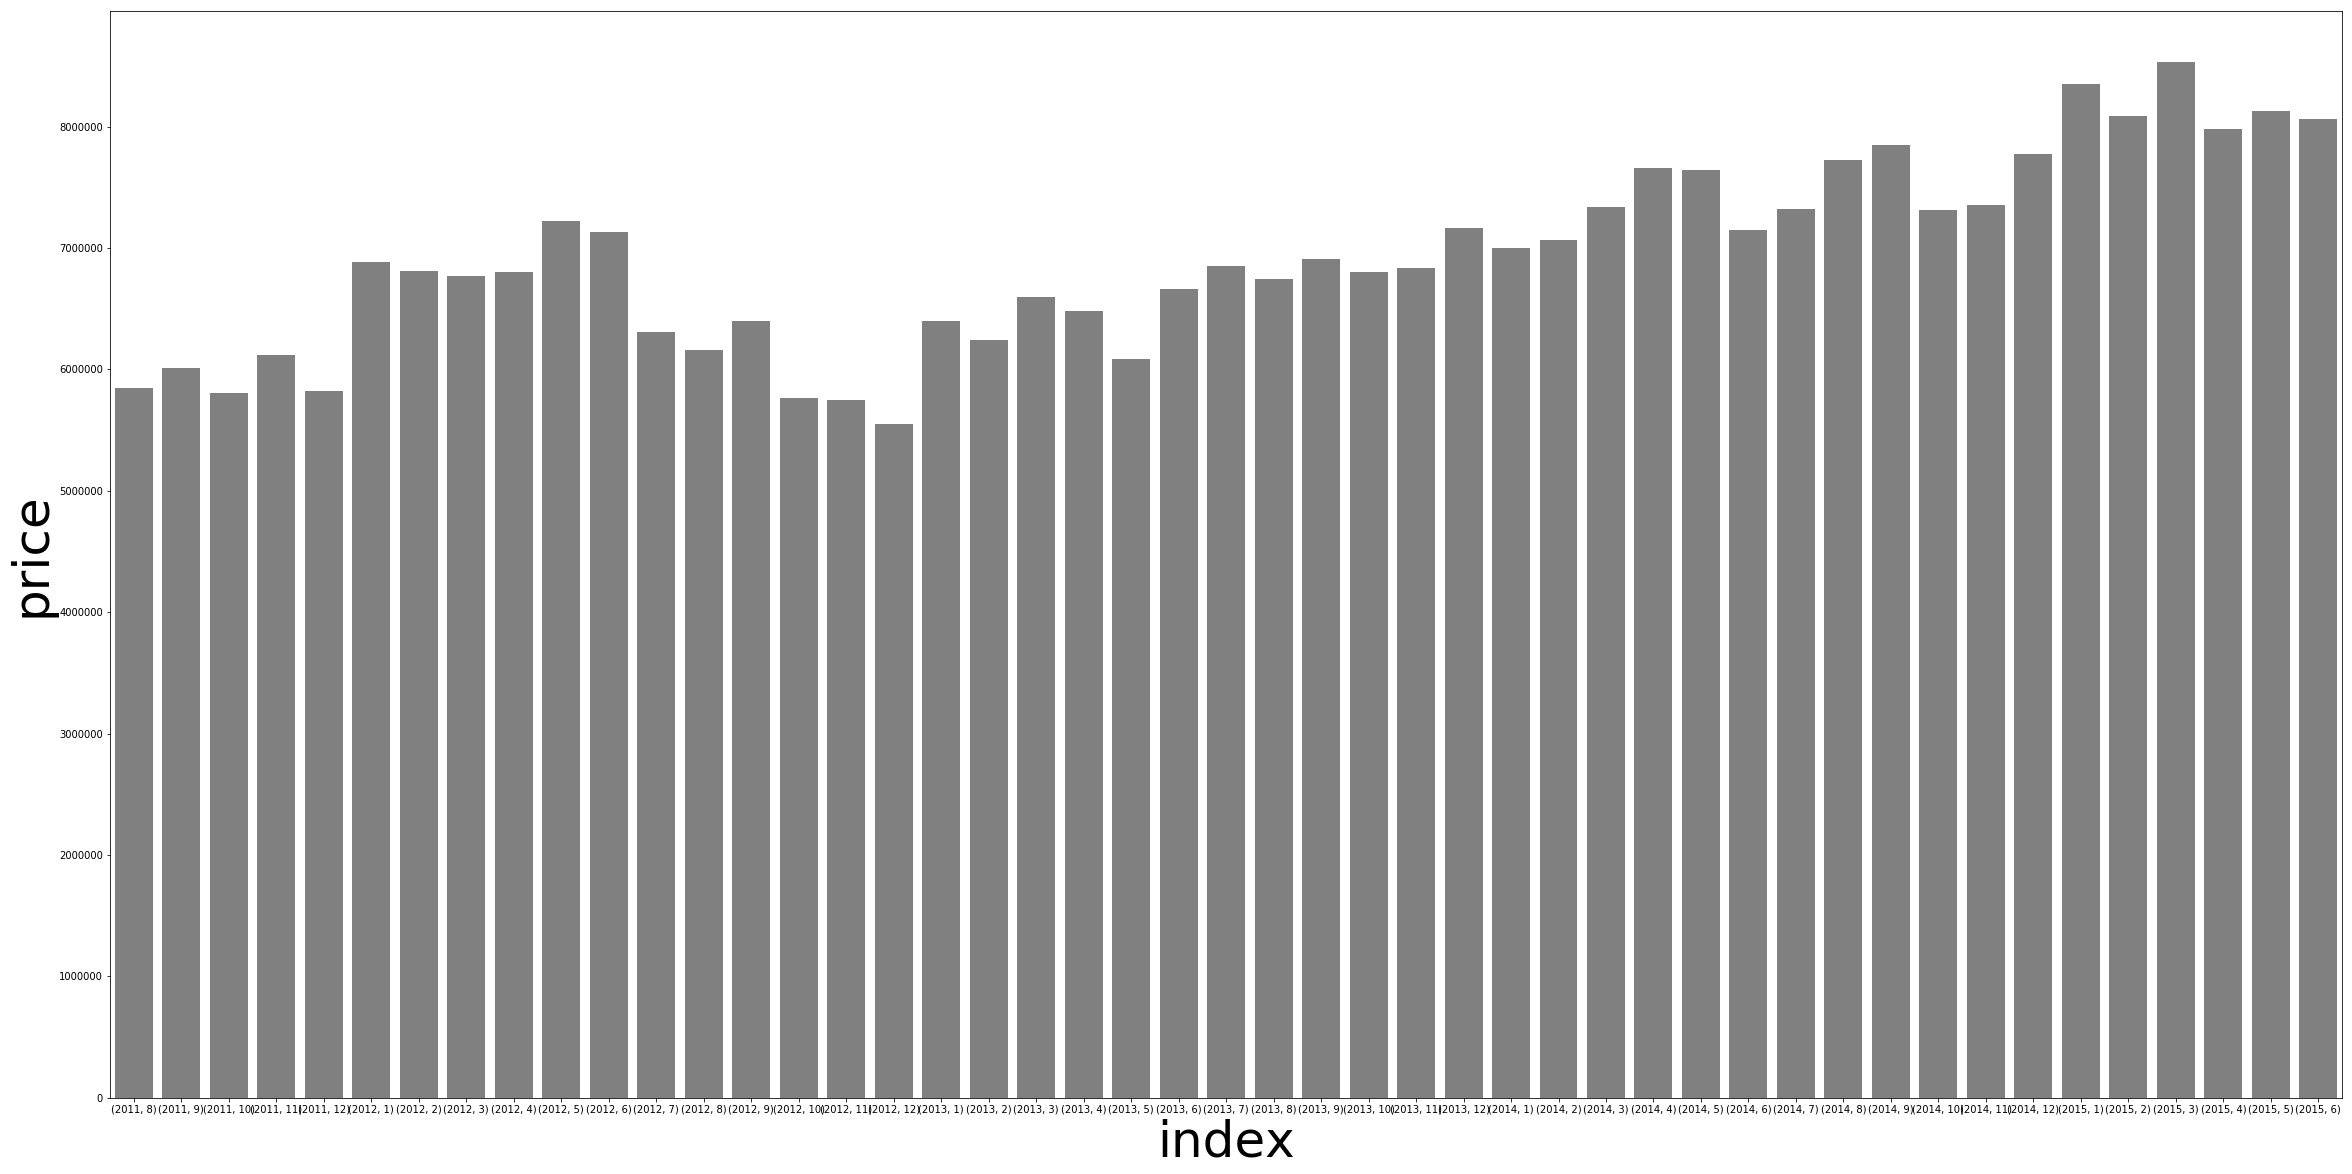

In [15]:
mean = pd.DataFrame(traindf.groupby([traindf["year"],traindf["month"]])["price_doc"].agg('mean').apply(lambda x : format(x,'10.0f')))
mean["price_doc"]=mean["price_doc"].astype(int)
mean["year"]= mean.index
#mean.reset_index(level=0, inplace=True)
plt.figure(figsize=(40,20))
sns.barplot(x="year",y="price_doc",data=mean, color="grey")
plt.xlabel('index', fontsize=50)
plt.ylabel('price', fontsize=50)
plt.show()

#plt.bar(range(mean.shape[0]),mean.price_doc.values)
#plt.xlabel('index', fontsize=50)
#plt.ylabel('price', fontsize=50)
#plt.show()

It seems like the average price is steadily increasing every year from the first chart. Specific months don't make a difference I guess, but there is a
steday growth in price after the first 18 months..So a combination of year and month might be useful inputs

In [52]:
#s=pd.Series(traindf.isnull().sum())
#print(s.sort_values(ascending=False))
print(traindf.describe)

<bound method NDFrame.describe of           id  timestamp  full_sq  life_sq  floor  max_floor  material  \
0          1 2011-08-20       43     27.0    4.0        NaN       NaN   
1          2 2011-08-23       34     19.0    3.0        NaN       NaN   
2          3 2011-08-27       43     29.0    2.0        NaN       NaN   
3          4 2011-09-01       89     50.0    9.0        NaN       NaN   
4          5 2011-09-05       77     77.0    4.0        NaN       NaN   
5          6 2011-09-06       67     46.0   14.0        NaN       NaN   
6          7 2011-09-08       25     14.0   10.0        NaN       NaN   
7          8 2011-09-09       44     44.0    5.0        NaN       NaN   
8          9 2011-09-10       42     27.0    5.0        NaN       NaN   
9         10 2011-09-13       36     21.0    9.0        NaN       NaN   
10        11 2011-09-16       36     19.0   12.0        NaN       NaN   
11        12 2011-09-16       38     19.0   11.0        NaN       NaN   
12        13 2011

In [53]:
print("Train Shape",traindf.shape)
print("Test Shape",testdf.shape)

Train Shape (30471, 294)
Test Shape (7662, 293)


Okay, 292 variables. We might not be able to visualize all variables, but we need ways to eliminate variables that do not influence price. And since this is a regression prediction problem, we could start by looking at 

1) variables with high level of null values

2) correlation and multicolleniarity to remove redundant variables to reduce variance using VIF

3) Significance of variables in predicting the outcome ; regression table output

4) stepwise selection/elimination to check which variables improve the model- feature importance


Let's look at each one of the above might need to look at correlation factors.

In [54]:
nulltable = pd.DataFrame(traindf.isnull().sum()/traindf.shape[0]).reset_index()
nulltable.columns = ['column_name', 'missing_count']
non_nullcolumns = nulltable[nulltable['missing_count']==0]
nulltable.sort_values(by="missing_count",ascending = 0).head(20)

,column_name,missing_count
24,hospital_beds_raion,0.473926
7,build_year,0.446490
10,state,0.444980
161,cafe_sum_500_max_price_avg,0.435857
160,cafe_sum_500_min_price_avg,0.435857
162,cafe_avg_price_500,0.435857
5,max_floor,0.314135
8,num_room,0.314135
9,kitch_sq,0.314135
6,material,0.314135


Highest degree of missing values is the hospital_beds_raion column with 47% . Let me remove variables with more than 10% missing values and impute -1 into the others.

In [71]:
null_columns_remove= list(nulltable[nulltable['missing_count']>.10]["column_name"])
print(traindf.shape)
print(testdf.shape)
traindf1 = traindf.drop(null_columns_remove,axis=1)
testdf1 = testdf.drop(null_columns_remove,axis=1)
print(traindf1.shape)
print(testdf1.shape)

(30471, 294)
(7662, 293)
(30471, 259)
(7662, 258)


In [72]:
datatype = traindf1.dtypes.reset_index()
datatype.columns = ['column_name', 'datatype']
datatype["datatype"].value_counts()

int64             159
float64            84
object             15
datetime64[ns]      1
Name: datatype, dtype: int64

In [73]:
table = pd.merge(nulltable,datatype, how="inner",on="column_name")
table["Null"] = np.where(table["missing_count"]==0,"No","Yes")
table["type"] = np.where(table["datatype"]=="object","Category","Number")
print("There are ",non_nullcolumns.shape[0],"columns with no null values and ",
     traindf1.shape[1]-non_nullcolumns.shape[0], "columns with null values that have been filled with -1 \n")
print(pd.crosstab(table.type,table["Null"]))

There are  243 columns with no null values and  16 columns with null values that have been filled with -1 

Null       No  Yes
type              
Category   15    0
Number    228   16


In [74]:
traindf1.fillna(-1,inplace=True)
testdf1.fillna(-1,inplace=True)

Below I will be looking at all the categorical variables to see how big the dataset will become once I encode it.

In [62]:
for i in table[table["datatype"]=="object"]["column_name"] :
    print("\n",i)
    print(traindf1[i].value_counts())


 product_type
Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

 sub_area
Poselenie Sosenskoe               1776
Nekrasovka                        1611
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
Mitino                             679
Tverskoe                           678
Krjukovo                           518
Mar'ino                            508
Poselenie Filimonkovskoe           496
Juzhnoe Butovo                     451
Poselenie Shherbinka               443
Solncevo                           421
Zapadnoe Degunino                  410
Poselenie Desjonovskoe             362
Otradnoe                           353
Nagatinskij Zaton                  327
Bogorodskoe                        305
Nagornoe                           305
Strogino                           301
Izmajlovo                          300
Tekstil'shhiki                     298
Ljublino                           29

I will be dropping sub_area for now. while it might be useful, it has too many categories and might require a lot of time to weed through once encoded. Other columns have relatively lower categories and will be easy to look at.

In [75]:
traindf2 = traindf1.drop("sub_area",axis=1)
testdf2 = testdf1.drop("sub_area",axis=1)
print("After removing sub_area, shape reduced from ", traindf1.shape,"to",traindf2.shape)

After removing sub_area, shape reduced from  (30471, 259) to (30471, 258)


In [78]:
traindf2 = pd.get_dummies(traindf2)
testdf2 = pd.get_dummies(testdf2)
print(traindf2.dtypes.value_counts())

int64             159
float64            84
uint8              31
datetime64[ns]      1
dtype: int64


So all categorical columns have now been converted

Let's look at multicollinearity

How does multicollinearity affect the coeffcients and the final predictions?Why should you solve for multicollinearity?

So in a multiple linear regression problem, we equate y = Ax1+bx2 +c . 
y- dependant
x1 and x2 being the independant variables that are correlated
c being the intercept or constant.

When you say y = ax1 + bx2 , you mean that for a unit increase in x1, y increase by a, all else being constant. And this should be a true relationship for y and x1 irrespective of what other variables we use. But if x2 is correlated with x1, the constant a seems to be decided by the order of variables fed into the regressor and also by the number of predictors. Slight multicollinearity is tolerable as the coefficients are not strongly influnced, but high multicollinearity makes the coeffs erratic and unreliable. So the prediction might fluctuate based on the number and order of variables, which shouldn't be the case.

Hence, removing colinear variable is a need for a stable regression model.
 VIF seems to be the goto way of detecting multicollinearity. 
 VIF is calculated by 1/(1-R^2), R^2 coming out of every variable being predicted by the others using a regression model. So, R2 tells you how much of the variation in a variable is explained by the other variables, and the higher the R2, bigger the relationhip between independant variables, and ergo higher is the value of 1/(1-R2). Typical cutoff seems to be 5 for removing variables 
 on account of multicollinearity, 1-(1-.8) would give you 5, which means if a 80% of variation in a variable can be explained by other variables, it needs to be removed and not fed into a model

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

    maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
        variables = np.delete(variables, maxloc)
        dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

X = traindf2.drop(['id','timestamp','price_doc'], axis =1)
calculate_vif_(X)



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'raion_popul' at index: 3
Remaining variables:
Index(['full_sq', 'floor', 'area_m', 'green_zone_part', 'indust_part',
       'children_preschool', 'preschool_education_centers_raion',
       'children_school', 'school_education_centers_raion',
       'school_education_centers_top_20_raion',
       ...
       'water_1line_yes', 'big_road1_1line_no', 'big_road1_1line_yes',
       'railroad_1line_no', 'railroad_1line_yes', 'ecology_excellent',
       'ecology_good', 'ecology_no data', 'ecology_poor',
       'ecology_satisfactory'],
      dtype='object', length=271)


,full_sq,floor,area_m,green_zone_part,indust_part,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,...,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,43,4.0,6.407578e+06,0.189727,0.000070,9576,5,10309,5,0,...,0,1,0,1,0,0,1,0,0,0
1,34,3.0,9.589337e+06,0.372602,0.049637,6880,5,7759,8,0,...,0,1,0,1,0,1,0,0,0,0
2,43,2.0,4.808270e+06,0.112560,0.118537,5879,4,6207,7,0,...,0,1,0,1,0,0,0,0,1,0
3,89,9.0,1.258354e+07,0.194703,0.069753,13087,9,13670,10,0,...,0,1,0,1,0,0,1,0,0,0
4,77,4.0,8.398461e+06,0.015234,0.037316,5706,7,6748,9,0,...,0,1,0,0,1,1,0,0,0,0
5,67,14.0,7.506452e+06,0.007670,0.486246,2418,2,2514,3,0,...,0,1,0,1,0,0,0,0,1,0
6,25,10.0,1.032047e+07,0.523439,0.042307,2459,5,2810,5,0,...,0,1,0,1,0,0,0,0,1,0
7,44,5.0,6.407578e+06,0.189727,0.000070,9576,5,10309,5,0,...,0,1,0,1,0,0,1,0,0,0
8,42,5.0,4.787424e+06,0.038456,0.122090,6507,4,6566,6,0,...,0,1,0,1,0,0,0,0,1,0
9,36,9.0,5.235177e+07,0.070662,0.035145,9347,7,9292,8,0,...,0,1,0,1,0,0,0,0,0,1


In [66]:
X = traindf2.drop(['id','timestamp','price_doc'], axis =1)
Y = traindf2['price_doc']

In [25]:
param_grid = [{"max_depth":[5,8,10], "max_features":["sqrt"]}]
grid = GridSearchCV(GradientBoostingRegressor(),param_grid, cv=3, n_jobs =-1)
grid.fit(X,Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [5, 8, 10], 'max_features': ['sqrt']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
gb = grid.best_estimator_
gb.fit(X,Y)
prediction =gb.predict(X)

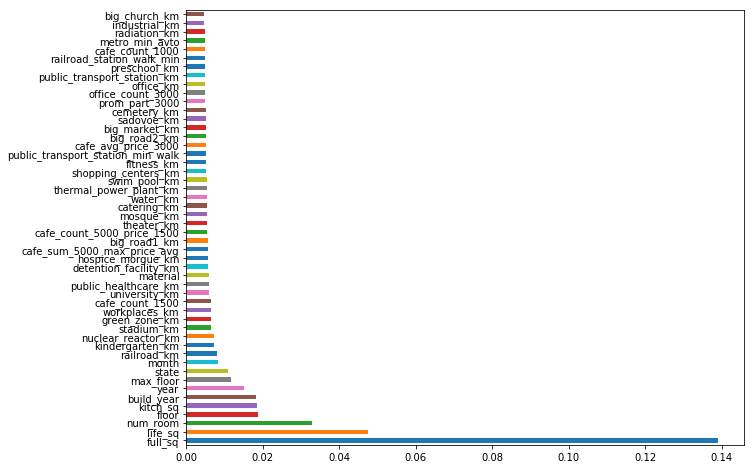

In [27]:
plt.figure(figsize=(10,8))
pd.Series(gb.feature_importances_, index=X.columns).nlargest(50).plot(kind='barh')

In [28]:
importantfeatures = pd.Series(gb.feature_importances_, index=X.columns).nlargest(50).reset_index()
importantfeatures.columns = ["columnname","importance"]
#columnlist= importantfeatures["columnname"]
columnlist = list(importantfeatures["columnname"])
columnlist

['full_sq',
 'life_sq',
 'num_room',
 'floor',
 'kitch_sq',
 'build_year',
 'year',
 'max_floor',
 'state',
 'month',
 'railroad_km',
 'kindergarten_km',
 'nuclear_reactor_km',
 'stadium_km',
 'green_zone_km',
 'workplaces_km',
 'cafe_count_1500',
 'university_km',
 'public_healthcare_km',
 'material',
 'detention_facility_km',
 'hospice_morgue_km',
 'cafe_sum_5000_max_price_avg',
 'big_road1_km',
 'cafe_count_5000_price_1500',
 'theater_km',
 'mosque_km',
 'catering_km',
 'water_km',
 'thermal_power_plant_km',
 'swim_pool_km',
 'shopping_centers_km',
 'fitness_km',
 'public_transport_station_min_walk',
 'cafe_avg_price_3000',
 'big_road2_km',
 'big_market_km',
 'sadovoe_km',
 'cemetery_km',
 'prom_part_3000',
 'office_count_3000',
 'office_km',
 'public_transport_station_km',
 'preschool_km',
 'railroad_station_walk_min',
 'cafe_count_1000',
 'metro_min_avto',
 'radiation_km',
 'industrial_km',
 'big_church_km']

In [40]:
print(traindf1["full_sq"].describe())
print(stats.skew(traindf1["full_sq"]))
print(stats.pearsonr(traindf1["full_sq"], traindf1["price_doc"]))
print(stats.spearmanr(traindf1["full_sq"], traindf1["price_doc"]))

count    30471.000000
mean        54.214269
std         38.031487
min          0.000000
25%         38.000000
50%         49.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64
88.54696347410487
(0.34184045975381705, 0.0)
SpearmanrResult(correlation=0.521644011644802, pvalue=0.0)


In [ ]:
for i in print(stats.pearsonr(traindf1["full_sq"], traindf1["price_doc"]))
print(stats.spearmanr(traindf1["full_sq"], traindf1["price_doc"]))

In [ ]:
X = df.assign(const=1)

In [29]:
model = sm.OLS(Y,traindf1[["kitch_sq","full_sq"]])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                 2.541e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:37:26   Log-Likelihood:            -5.1475e+05
No. Observations:               30471   AIC:                         1.029e+06
Df Residuals:                   30469   BIC:                         1.030e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
kitch_sq    1.763e+04   1266.621     13.920      0.0

In [438]:
model = sm.OLS(Y,traindf1[columnlist])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     2383.
Date:                Mon, 04 Feb 2019   Prob (F-statistic):               0.00
Time:                        22:30:45   Log-Likelihood:            -5.0543e+05
No. Observations:               30471   AIC:                         1.011e+06
Df Residuals:                   30421   BIC:                         1.011e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
full_sq           

In [439]:
predictions = results.predict(traindf1[columnlist])
predictions.head()

0    4.298589e+06
1    5.233382e+06
2    5.089663e+06
3    7.628342e+06
4    1.147460e+07
dtype: float64

In [444]:
def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))
rmsle(Y,prediction)

0.3996751594622287